## GCM Filters on Irregular Grids with Irregular Filter Scale 

This notebook will use data from the idealized one-basin NeverWorld2 configuration performed in MOM6.

We will filter data which is on an irregular grid (hozirontal grid spacing dx varies with latitude, dy is constant).

## Handling various model resolutions

We define one spatial filter based on the 1/4 degree grid.

We then read in higher-resolution data and coarsen the fields that we're filtering using xarray.Dataset.coarsen onto the 1/4 degree grid.

We then perform the filtering and interpolate the filtered field back onto the high-resolution grid.

In [28]:
%reset
import xesmf as xe
import gcm_filters
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import cmocean
from xgcm import Grid
print('done')

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


done


### Execute the following cell to read in NW2 data for 1/4 (run 20) degree 

In [29]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
fs025 = xr.open_dataset('static.nc', decode_times=False)
av025 = xr.open_dataset('averages_00031502.nc', decode_times=False)  #100 5-day averages

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.25deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [30]:
Nx = np.size(av025.xh)
xhp = av025.xh
Ny = np.size(av025.yh)
yhp = av025.yh
print('Nx = %i, Ny = %i' %(Nx,Ny))

Nx = 240, Ny = 560


### To filter with fixed filter length scale, we will use the grid type: IRREGULAR_CARTESIAN_WITH_LAND, and its associated Laplacian. The Laplacian needs the following grid variables:

In [31]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)


['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

In [32]:
wet_mask = fs025.wet
area = fs025.area_t

# Grid define for computations 
grid = Grid(av025, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'}});


For the remaining grid variables, recall the following conventions:

dxw = x-spacing centered at western cell edge

dyw = y-spacing centered at western cell edge

dxs = x-spacing centered at southern cell edge

dys = y-spacing centered at southern cell edge

We get these grid variables from our model output as follows:

In [33]:
dxw = xr.DataArray(data=fs025.dxCu.isel(xq=slice(0,Nx)),coords={'yh':av025.yh,'xh':av025.xh}, dims=('yh','xh'))
dyw = xr.DataArray(data=fs025.dyCu.isel(xq=slice(0,Nx)),coords={'yh':av025.yh,'xh':av025.xh}, dims=('yh','xh'))
dxs = xr.DataArray(data=fs025.dxCv.isel(yq=slice(0,Ny)),coords={'yh':av025.yh,'xh':av025.xh}, dims=('yh','xh'))
dys = xr.DataArray(data=fs025.dyCv.isel(yq=slice(0,Ny)),coords={'yh':av025.yh,'xh':av025.xh}, dims=('yh','xh'))

In [34]:
print('our filter scale is set by a function related to the deformation radius')
Ld = xr.DataArray(av025.Rd1.mean(dim='time'))
Ld = Ld.fillna(np.nanmax(Ld))
Ld[0:60,:]=Ld[60,:].mean('xh')
Ld[500:560,:]=Ld[500,:].mean('xh')

#Defining filter scale to be 5 times deformation radius, except near the equator where it is set to 500km.
fscale = (Ld.mean('xh'))*5; fscale[200:360]=500000.
fscale = 0.*Ld+fscale

print(np.nanmin(Ld),np.nanmax(Ld))
print(Ld)

our filter scale is set by a function related to the deformation radius
273.93668 445152.75
<xarray.DataArray 'Rd1' (yh: 560, xh: 240)>
array([[20854.436, 20854.436, 20854.436, ..., 20854.436, 20854.436,
        20854.436],
       [20854.436, 20854.436, 20854.436, ..., 20854.436, 20854.436,
        20854.436],
       [20854.436, 20854.436, 20854.436, ..., 20854.436, 20854.436,
        20854.436],
       ...,
       [39591.105, 39591.105, 39591.105, ..., 39591.105, 39591.105,
        39591.105],
       [39591.105, 39591.105, 39591.105, ..., 39591.105, 39591.105,
        39591.105],
       [39591.105, 39591.105, 39591.105, ..., 39591.105, 39591.105,
        39591.105]], dtype=float32)
Coordinates:
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88


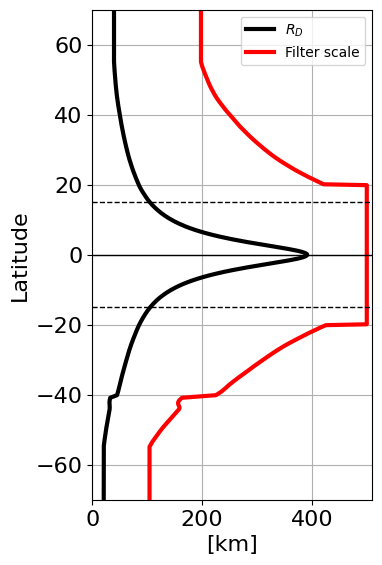

In [35]:
fig = plt.figure(figsize=(4, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.7,0.7]) 

ax1.set_xlabel('[km]',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

ax1.plot(Ld.mean('xh')/1000,yhp,'k',linewidth=3)
ax1.plot(fscale.mean('xh')/1000,yhp,'r',linewidth=3)

ax1.plot([0,1000],[0,0],'k',linewidth=1)
ax1.plot([0,1000],[15,15],'--k',linewidth=1)
ax1.plot([0,1000],[-15,-15],'--k',linewidth=1)


ax1.set_xlim([0,510])
ax1.set_ylim([-70,70])
ax1.grid('on')

plt.legend(['$R_D$','Filter scale'])
plt.show()

### The filter needs to know what the minimum grid spacing is in our model.

In [36]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_max = max(dxw.max(),dyw.max(),dxs.max(),dys.max())

dx_min = dx_min.values
dx_max = dx_max.values
dx_min, dx_max

(array(9518.17259783), array(27829.27492305))

### Setting the filter scale:

In [37]:
#using filter scale that's a function of zonally averaged Ld*5, 500km near equator
Lf = np.max(fscale.data)
filter_scale = Lf
kappa_w = fscale**2 / Lf**2
kappa_s = fscale**2 / Lf**2

### Defining the filter:

In [38]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    transition_width=2*np.pi,
    n_steps=70, #0 is default
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 
               'area': area, 'kappa_w': kappa_w, 'kappa_s': kappa_s}
)
filter

n_steps = 70


Filter(filter_scale=500000.0, dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=6.283185307179586, ndim=2, n_steps=70, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

### Now we read in the data set to be filtered.

In [47]:
# #1/4 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)  #100 5-day averages
# cfac=1

#For 1/32 degree:
#1/32 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
fs = xr.open_dataset('static.nc', decode_times=False)
av = xr.open_dataset('averages_00002702.nc', decode_times=False)  #20 5-day averages
#av = xr.open_mfdataset(['averages_00002302.nc','averages_00002402.nc','averages_00002502.nc','averages_00002602.nc','averages_00002702.nc'], decode_times=False)  #20 5-day averages
cfac=8 

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.03125deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


### Interpolating the velocities onto thickness points and coarsening to 0.25 degree grid:

In [48]:
%%time

# Grid define for computations 
gridhr = Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
xhhr = av.xh
yhhr = av.yh

ufull = av.u[:,:,:,:]; 
u_interp= gridhr.interp(ufull,axis='X')#.fillna(0.) #interpolating onto thickness points

vfull = av.v[:,:,:,:];
v_interp=gridhr.interp(vfull,axis='Y')#.fillna(0.) #interpolating onto thickness points

h = (av.h[:,:,:,:]).mean(dim='time')#.fillna(0.)
depth=fs.depth_ocean#.fillna(0.)

u_interp_coarse = u_interp.coarsen(xh=cfac,yh=cfac, boundary="exact").mean() #coarsening
v_interp_coarse = v_interp.coarsen(xh=cfac,yh=cfac, boundary="exact").mean() #coarsening
print(u_interp_coarse.shape)

(20, 15, 560, 240)
CPU times: user 2min 33s, sys: 1min 30s, total: 4min 3s
Wall time: 4min 12s


### Defining the regridder that will place our coarsened and filtered data back onto the high resolution grid

In [49]:
%%time
ds_for_regridder = u_interp_coarse[0,:,:,:]
#Define regridder
ds_out = xr.Dataset({'lat': (['lat'], yhhr),
                     'lon': (['lon'], xhhr),
                    }
                   )
ds = ds_for_regridder.rename({'xh': 'lon', 'yh': 'lat'})
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder


/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/xarray/core/dataarray.py:738: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CPU times: user 2min 24s, sys: 9.76 s, total: 2min 34s
Wall time: 2min 34s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_560x240_4480x1920.nc 
Reuse pre-computed weights? False 
Input grid shape:           (560, 240) 
Output grid shape:          (4480, 1920) 
Periodic in longitude?      False

In [50]:
%%time
print('Filtering on coarse grid, interpolating filtered field back onto high resolution grid')
#Initialize zero arrays for the mean velocity components:
u_mean=xr.zeros_like(u_interp); 
v_mean=xr.zeros_like(v_interp); 
#u_interp and v_interp are the unfiltered velocities

for i in range(20): #100 5-day averages, so total 500 day span
    #filtering on low res grid
    u_mean_lr = (filter.apply(u_interp_coarse[i,:,:,:], dims=['yh', 'xh'])).fillna(0.)  #3D field
    v_mean_lr = (filter.apply(v_interp_coarse[i,:,:,:], dims=['yh', 'xh'])).fillna(0.)  #3D field
    #Placing back on the high-resolution grid:
    u_mean[i,:,:,:] = regridder(u_mean_lr);                                           
    v_mean[i,:,:,:] = regridder(v_mean_lr);
    print(i)


Filtering on coarse grid, interpolating filtered field back onto high resolution grid


/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('yh', 'xh') from data variable None as the horizontal dimensions for the regridding.
  UserWarning,


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 4min 59s, sys: 16.5 s, total: 5min 16s
Wall time: 5min 16s


### Now we compute the eddy components and then the KE corresponding to mean/eddy/BT/BC parts.

In [51]:
%%time
#We will remove the stationary part of the small scale flow and add it to the mean:
u_eddy = (u_interp-u_mean)
stationary_small_u = u_eddy.mean('time')
u_eddy = u_eddy-stationary_small_u

v_eddy = (v_interp-v_mean)#.fillna(0.); 
stationary_small_v = v_eddy.mean('time')
v_eddy = v_eddy-stationary_small_v


#Splitting into Barotropic (BT) and Baroclinic (BC)
u_BT_eddy = (u_eddy*h/depth).sum('zl')
v_BT_eddy = (v_eddy*h/depth).sum('zl')
u_BC_eddy = (u_eddy-u_BT_eddy)
v_BC_eddy = (v_eddy-v_BT_eddy)


#Computing Kinetic Energy components:
KE_BT_eddy = 0.5*(u_BT_eddy**2+v_BT_eddy**2)
KE_BC_eddy = (0.5*(u_BC_eddy**2+v_BC_eddy**2)*h/depth).sum('zl')

print('done 1')

#Totals:
u_BT = (u_interp*h/depth).sum('zl'); u_BC = u_interp-u_BT
v_BT = (v_interp*h/depth).sum('zl'); v_BC = v_interp-v_BT

print('done 2')
KE_BT= 0.5*(u_BT**2+v_BT**2)
KE_BC= (0.5*(u_BC**2+v_BC**2)*h/depth).sum('zl')
KE_TOT = KE_BT+KE_BC
KE_TOT=KE_TOT.where(KE_TOT>1e-4)


print('Done, but KE values still need to be averaged in time')

done 1
done 2
Done, but KE values still need to be averaged in time
CPU times: user 2min 9s, sys: 3min 30s, total: 5min 40s
Wall time: 5min 41s


In [44]:
##For saving 1/4 degree results:
fraction_BT_025=(KE_BT.mean('time')/KE_TOT.mean('time'))
fraction_BT_eddy_025=(KE_BT_eddy.mean('time')/KE_TOT.mean('time'))

fraction_BC_025=KE_BC.mean('time')/KE_TOT.mean('time')
fraction_BC_eddy_025=KE_BC_eddy.mean('time')/KE_TOT.mean('time')

xh025  = xhhr
yh025  = yhhr
print('done')

done


In [55]:
##For saving 1/32 degree results:
fraction_BT_003125=(KE_BT.mean('time')/KE_TOT_f.mean('time'))
fraction_BT_eddy_003125=(KE_BT_eddy.mean('time')/KE_TOT_f.mean('time'))

fraction_BC_003125=KE_BC.mean('time')/KE_TOT_f.mean('time')
fraction_BC_eddy_003125=KE_BC_eddy.mean('time')/KE_TOT_f.mean('time')

xh003125  = xhhr
yh003125  = yhhr
print('done')

done


done


Text(0.5, 1.0, '1/4$^\\circ$ KE Fractions')

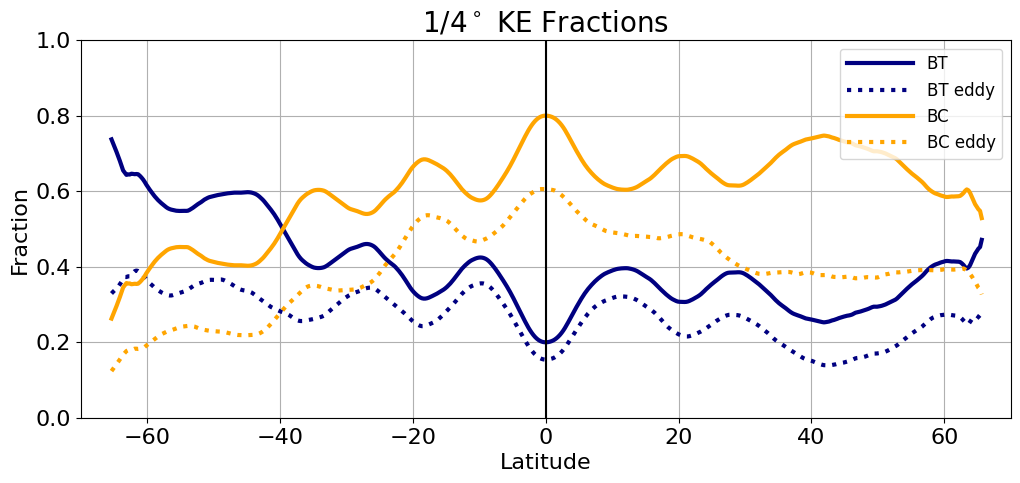

In [46]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh025,np.convolve((fraction_BT_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
plt.plot(yh025,np.convolve((fraction_BT_eddy_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()
plt.plot(yh025,np.convolve((fraction_BC_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.plot(yh025,np.convolve((fraction_BC_eddy_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c='#FFA500',linewidth=3)

plt.legend(['BT','BT eddy','BC','BC eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/4$^\circ$ KE Fractions',fontsize=20)

done


Text(0.5, 1.0, '1/32$^\\circ$ KE Fractions')

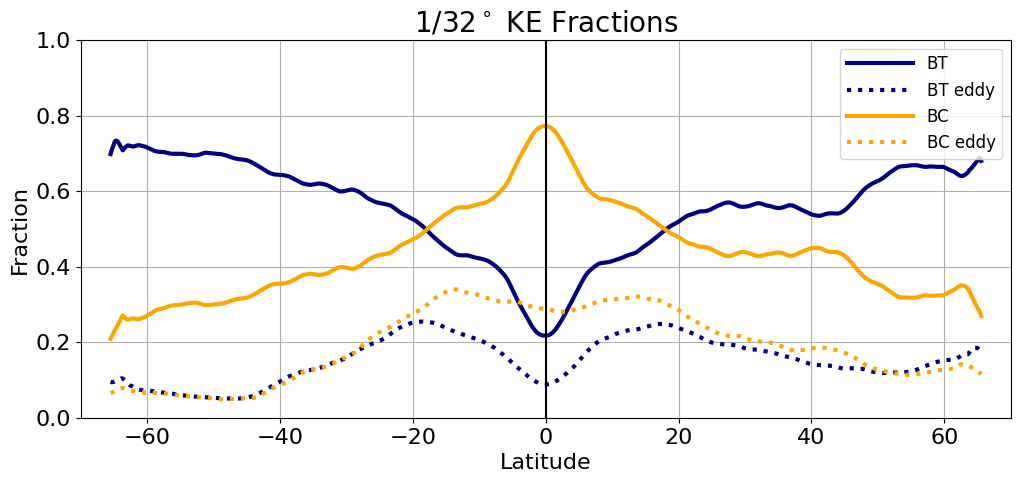

In [59]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=240

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh003125,np.convolve((fraction_BT_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
plt.plot(yh003125,np.convolve((fraction_BT_eddy_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()
plt.plot(yh003125,np.convolve((fraction_BC_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.plot(yh003125,np.convolve((fraction_BC_eddy_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c='#FFA500',linewidth=3)

plt.legend(['BT','BT eddy','BC','BC eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/32$^\circ$ KE Fractions',fontsize=20)